# Modele final

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data_2019 = pd.read_csv('valeursfoncieres-2019.txt',sep='|')
data_2018 = pd.read_csv('valeursfoncieres-2018.txt',sep='|')
#data_2020 = pd.read_csv('valeursfoncieres-2020.txt',sep='|')
#data_2017 = pd.read_csv('valeursfoncieres-2017.txt',sep='|')


C:\Users\Pirlouit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Pirlouit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,23,24,26,28,29,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_2019 = data_2019.copy()
df_2018 = data_2018.copy()
#df_2020 = data_2020.copy()
#df_2017 = data_2017.copy()


In [120]:
df = pd.concat([df_2018,df_2019],axis=0)

In [121]:
df['Type de voie']=='RUE'

0          True
1          True
2          True
3          True
4          True
           ... 
3142947    True
3142948    True
3142949    True
3142950    True
3142951    True
Name: Type de voie, Length: 6472099, dtype: bool

# Fonctions de preprocessing

In [122]:
def feature_selection(df): #on regroupe toutes les modifications qu'on fait sur le dataset dans une fonction preprocessing 
   # df = df[df['Commune']=='LILLE'] #on ne garde que les valeurs pour Lille ici
    df = df[(df['Code departement']== 59) | (df['Code departement']== 62) ]

    df = df[df['Nature mutation']=='Vente']
    df = df[df['Nature mutation'].isna()==False] #on ne garde que les mutations de type vente ou vente en l'état futur d'achevement
    df = df[df['Surface reelle bati'].isna()==False] 
    df = df[df['Surface reelle bati']!=0] #on supprime les colonnes ou la surface bati est 0
    df = df[df['Surface terrain']!=0] #on supprime les colonnes ou la surface bati est 0
    df = df[df['Nombre pieces principales'].isna()==False] 
    df = df[df['Type local'].isna()==False] 
    df = df[df['Type de voie'].isna()==False] 
    df = df[df['Valeur fonciere'].isna()==False] 
    df = df[df['Nombre de lots']<2]
    df = df.drop('Surface Carrez du 1er lot',axis=1)
    df = df.drop('Surface terrain',axis=1)
    df = df.drop('Nature culture',axis=1)
    df = df.drop('1er lot',axis=1)
    df = df.drop('No disposition',axis=1)
    
        
    df = df[df['Surface reelle bati']<320]
    df = df[df['Type local']!='Local industriel. commercial ou assimilé']
    df = df[df['Type local']!='Maison'] #on ne garde que les appartements pour finir
    df = df[df.columns[(df.isna().sum()/df.shape[0] < 0.80)]] #on supprime les colonnes qui ont plus de 80% de manquants
    df = df.dropna(axis=0)
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(',','.')
    df['Valeur fonciere']=pd.to_numeric(df['Valeur fonciere'], errors='coerce')    
    df = df[df['Valeur fonciere']<1000000] #on supprime les biens dont la valeur est supérieure à 1 millions (outliers)
    df = df[df['Valeur fonciere']>100000] #on supprime les biens dont la valeur est inferieure a 100k (outliers)
    df = df.drop('No voie',axis=1) #numero de la maison inutile pour faire une prediction cela pourrait fausser le modele
    df = df.drop('Code departement',axis=1) #tous dans le même departement pour l'instant donc inutile, a voir pour la suite
    #on va provisoirement dropper les donnees en dessous, on va les encoder par la suite
   # df = df.drop('Commune',axis=1) #pareil, pour l'instant on travaille que sur Lille
    df = df.drop('Code commune',axis=1) #plusieurs villes avec le meme code commune, on va encoder nous-mêmes les villes
    df = df.drop('Type local',axis=1) #pas besoin car on a seulement gardé les appartements
    df = df.drop('Code type local',axis=1) 
    df = df.drop('Nature mutation',axis=1) #pareil, on a seulement gardé les type 'Vente'
    df = df.drop('Nombre de lots',axis=1) #on a garde seulement nombre de lots égal à 0 ou 1 donc pas besoin de cette variable
  #  df = df.drop('Voie',axis=1) #il faut encoder cette valeur pour l'utiliser (cest le nom de la rue donc tres important)

    
    df = df.drop('Section',axis=1) #pas pratique pour l'utilisateur de devoir entrer la section mais important pour localiser l'appart
  #  df = df.drop('Type de voie',axis=1) 
    df = df.drop('No plan',axis=1)
    
    df = df.drop('Code voie',axis=1) #on a deja la variable Voie
   # df = df.drop('Date mutation',axis=1) 
    return df
    
df = feature_selection(df)

MemoryError: Unable to allocate 790. MiB for an array with shape (16, 6472099) and data type float64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

df['Voie'] = df['Voie']+'_'+df['Commune']
 #encodage en ordinal sur les voies
ordinalencoder_voie = OrdinalEncoder()
encoded = ordinalencoder_voie.fit_transform(df['Voie'].values.reshape(df['Voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Voie_'] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Voie',axis=1) 
#encodage ordinal sur les type de voie
ordinalencoder_typevoie = OrdinalEncoder()
encoded = ordinalencoder_typevoie.fit_transform(df['Type de voie'].values.reshape(df['Type de voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Type de voie_'] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Type de voie',axis=1) 

#encodage de la date

#on cree une colonne 'mois' et 'annee' a partir de la colonne date
df['Mois'] = 0
df['Annee'] = 0
for i in range(df.shape[0]):
    df['Mois'][i] = int((df['Date mutation'][i])[3:5])
    df['Annee'][i] = int((df['Date mutation'][i])[6:10])
df = df.drop('Date mutation',axis=1) 

#encodage ordinal Commune

ordinalencoder_commune = OrdinalEncoder()
encoded = ordinalencoder_commune.fit_transform(df['Commune'].values.reshape(df['Commune'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Commune_'] ) 
df =df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Commune',axis=1) 

#on passe la surface au carré pour augmenter l'ecart
#df['Surface reelle bati'] = df['Surface reelle bati']*df['Surface reelle bati']
#suppression des outliers
df = df[(np.abs(stats.zscore(df)) < 2.5).all(axis=1)] #pour filtrer les outliers selon le score Z(calculer avec moyenne et ecart type)


In [ ]:
df


# Creation des train/test sets

In [ ]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df,test_size=0.2,random_state=0)
y_test = testset['Valeur fonciere']
y_train = trainset['Valeur fonciere']

X_test = testset.drop('Valeur fonciere',axis=1)
X_train = trainset.drop('Valeur fonciere',axis=1)


# Modele

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_classif, k=8))
model_f = make_pipeline(preprocessor, RandomForestRegressor(random_state=0,n_estimators=160,max_features='sqrt',min_samples_split=2,max_depth=30, bootstrap='True' ) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse


In [ ]:
from sklearn.model_selection import learning_curve
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
    

# Quelques chiffres sur la performance du modele

In [12]:
(sum(abs(y_test-y_pred) < 20000)/y_test.shape[0])*100 #56% des valeurs prédites à 20k pres

55.139744197063

In [49]:
(sum(abs(y_test-y_pred) < 50000)/y_test.shape[0])*100 #76% des valeurs sont prédites à 50k pres

75.48113933795227

In [50]:
(sum(abs(y_test-y_pred) < 10000)/y_test.shape[0])*100 #43% des valeurs sont prédites à 10k pres

43.87990762124711

In [51]:
(sum(abs(y_test-y_pred) < 100000)/y_test.shape[0])*100 #90% des valeurs sont prédites à 100k pres

90.99307159353349

In [50]:
(sum(abs(y_test-y_pred) < 1000)/y_test.shape[0])*100 #43% des valeurs sont prédites à 10k pres

14.665401044138585

# Interface utilisateur

- Encoder les donnees entrees par l'utilisateur

In [16]:
X_train.columns

Index(['Code postal', 'Surface reelle bati', 'Nombre pieces principales',
       'Voie_', 'Type de voie_', 'Mois', 'Annee', 'Commune_'],
      dtype='object')

In [35]:
voie = np.array(['DU MAGASIN_LILLE'])
voie_enc = ordinalencoder_voie.transform(voie.reshape(-1,1))
voie_enc

array([[1295.]])

In [36]:
voie_transf = ordinalencoder_voie.inverse_transform(voie_enc)

In [100]:
Type_voie = np.array(['RUE'])
ordinalencoder_typevoie.transform(Type_voie.reshape(-1,1))[0][0]

25.0

In [131]:
Code_postal = 59000
Surface = 75
Nb_pieces = 4
Voie = np.array(['COLBERT_LILLE'])
Type_voie = np.array(['RUE'])

Mois = 6
Annee = 2019
Commune = np.array(['LILLE'])

X_pred = np.array([Code_postal, Surface, Nb_pieces, ordinalencoder_voie.transform(Voie.reshape(-1,1))[0][0], ordinalencoder_typevoie.transform(Type_voie.reshape(-1,1))[0][0], Mois, Annee, ordinalencoder_commune.transform(Commune.reshape(-1,1))[0][0]])

In [132]:
X_pred

array([5.900e+04, 5.625e+03, 4.000e+00, 2.400e+02, 2.500e+01, 6.000e+00,
       2.019e+03, 1.240e+02])

In [133]:
model_f.predict(X_pred.reshape(1,8))

array([148595.4962963])

Chez guigui : 146520
Desti : 135931

L'ecart est petit c'est bizarre : visualiser l'erreur en fonction de la surface pour voir s'il predit mal les appart + ou - grand
attention la surface est mise au carre dans l encodage aussi pour essayer d'augmenter la difference de surface

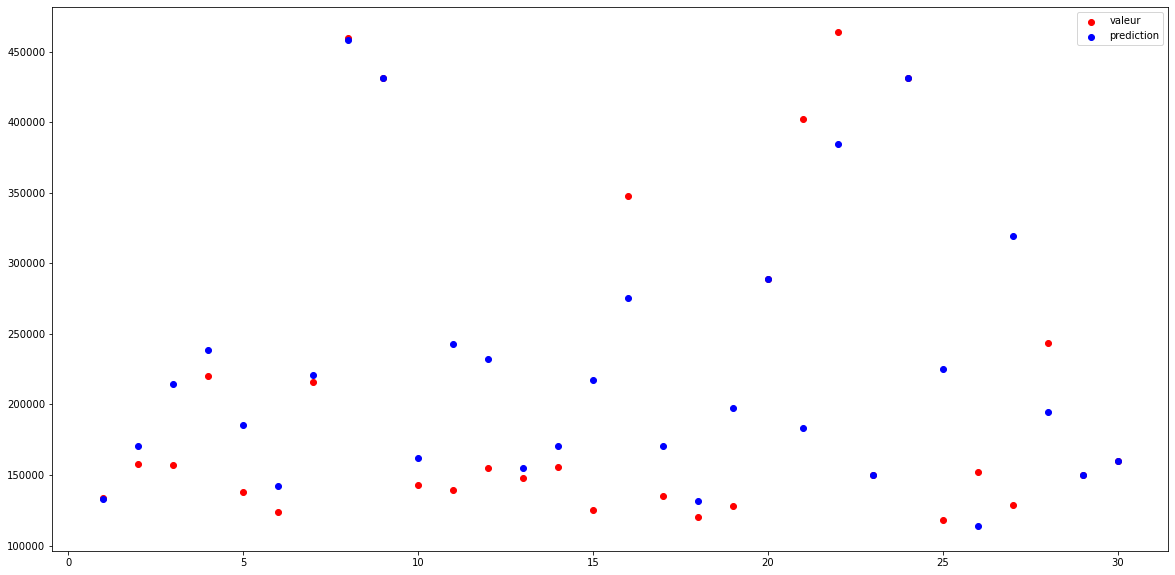

In [78]:
plt.figure(figsize=(20,10))

plt.scatter(x=np.linspace(1,30,30),y=y_test[50:80],label='valeur',c='r')
plt.scatter(x=np.linspace(1,30,30),y=y_pred[50:80],label='prediction',c='b')
plt.legend()

In [79]:

model_f[1].feature_importances_

array([0.12186234, 0.12177138, 0.12309876, 0.13082544, 0.14886385,
       0.16396619, 0.06180817, 0.12780387])

In [80]:
X_train.columns

Index(['Code postal', 'Surface reelle bati', 'Nombre pieces principales',
       'Voie_', 'Type de voie_', 'Mois', 'Annee', 'Commune_'],
      dtype='object')

16% pour le mois, et seulement 12% pour la surface, ce n'est pas normal

In [28]:
from sklearn.linear_model import LinearRegression


In [29]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

127042.44781190493

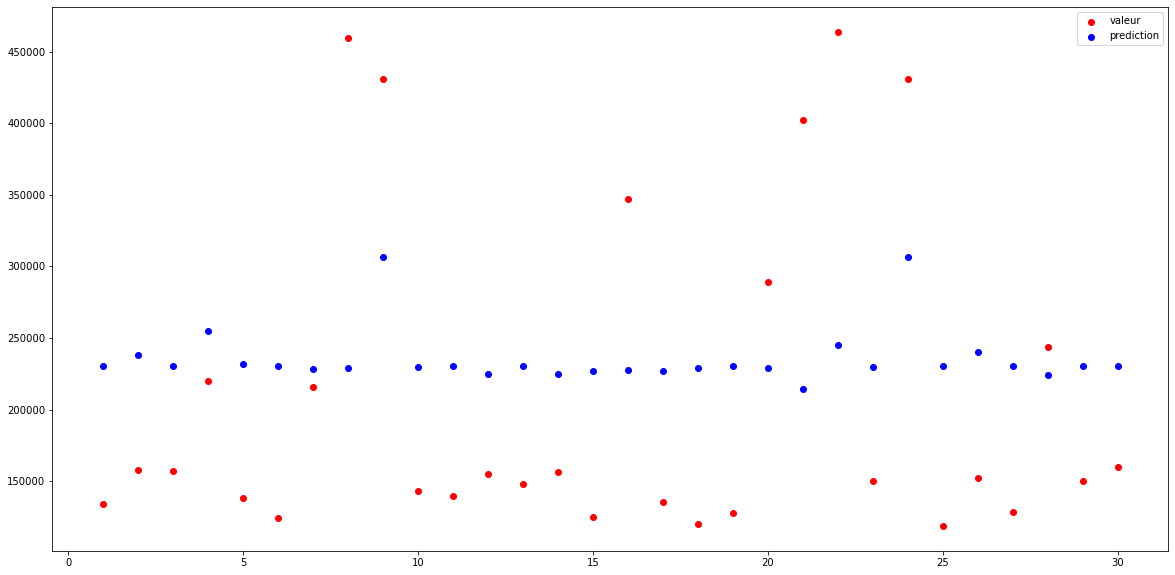

In [50]:
plt.figure(figsize=(20,10))

plt.scatter(x=np.linspace(1,30,30),y=y_test[50:80],label='valeur',c='r')
plt.scatter(x=np.linspace(1,30,30),y=y_pred[50:80],label='prediction',c='b')
plt.legend()

In [48]:
preprocessor = make_pipeline(PolynomialFeatures(degree=7, include_bias=False), SelectKBest(f_classif, k=8))
model = make_pipeline(preprocessor, StandardScaler(), LinearRegression() )


In [49]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

127565.72602129114

In [87]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

136900.7334732371

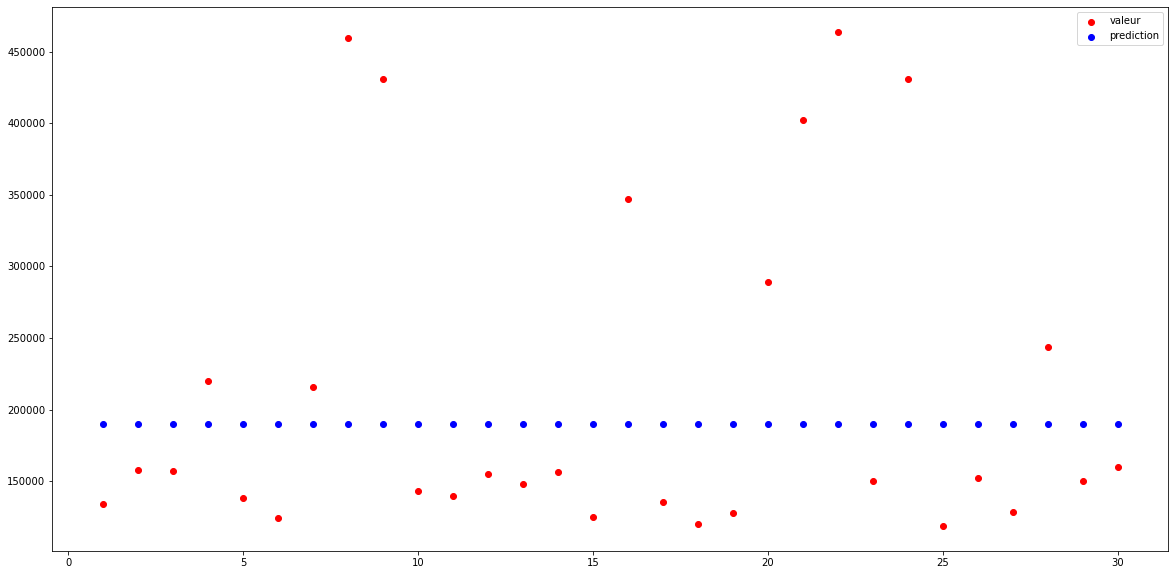

In [88]:
plt.figure(figsize=(20,10))

plt.scatter(x=np.linspace(1,30,30),y=y_test[50:80],label='valeur',c='r')
plt.scatter(x=np.linspace(1,30,30),y=y_pred[50:80],label='prediction',c='b')
plt.legend()

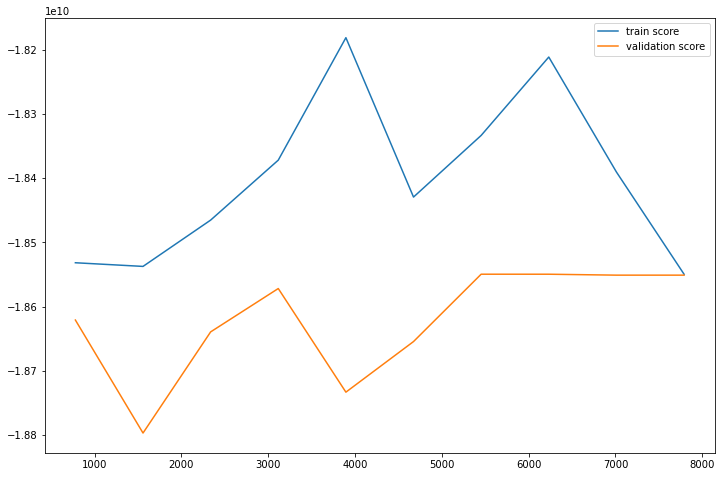

In [116]:
from sklearn.model_selection import learning_curve
N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
    